In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-04-03 23:19:03.123357: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels_new.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
labels = labels.astype(np.float64)

In [6]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually

In [7]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [8]:
#import json

In [9]:
#with open("image_data_v3.json", "r") as fp:
#    image_data = json.load(fp)
#with open("label_data_v3.json", "r") as fp:
#    label_data = json.load(fp)

In [10]:
#X_train = images[0:image_data['84']] 
#y_train = labels[0:label_data['84']]
#X_val = images[image_data['84']:]
#y_val = labels[label_data['84']:]

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


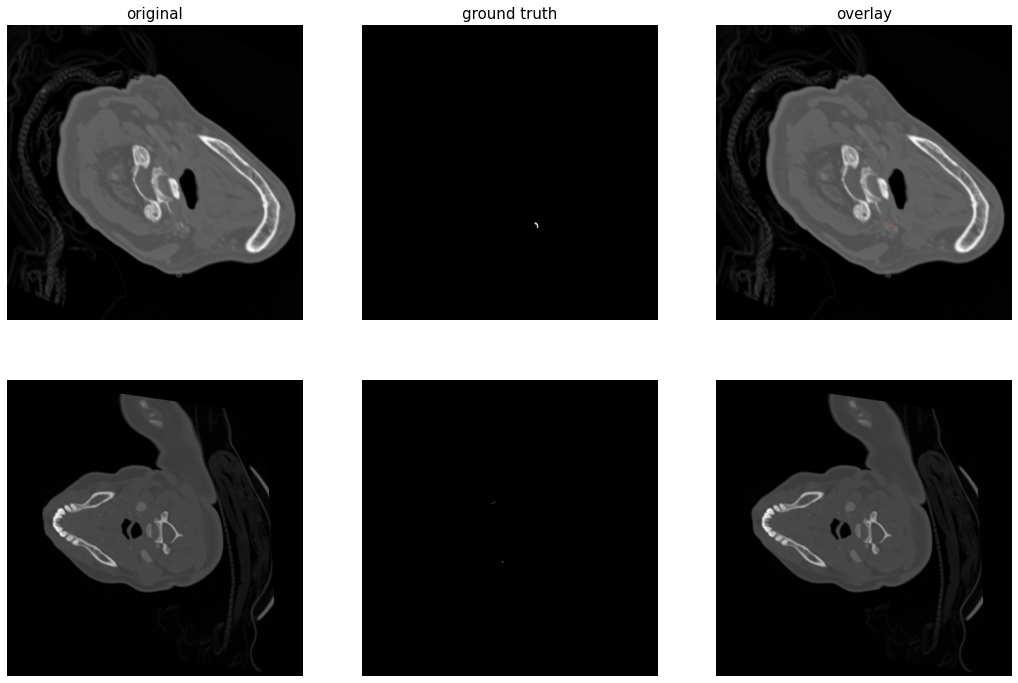

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2, 
    dropout_change_per_layer=0.0,
    num_layers=4,
    output_activation='sigmoid')

2023-04-03 23:19:21.044939: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-03 23:19:21.233255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-03 23:19:21.233292: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-03 23:19:21.236148: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-03 23:19:21.236182: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-03 23:19:21.236961: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [18]:
history = model.fit(X_train,
                    y_train,
                    32,
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-03 23:19:23.247754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-03 23:19:23.269169: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-03 23:19:24.575033: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-03 23:19:25.423765: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-03 23:19:26.501797: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-03 23:19:26.501820: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-03 23:19:26.502214: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-03 23:19:26.593183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-03 23:19:27.634129: I tensorflow/stream_exec

20/20 [==============================] - 55s 2s/step - loss: 1.5259 - iou: 1.2645e-04 - iou_thresholded: 8.4152e-04 - val_loss: 0.0062 - val_iou: 3.5365e-05 - val_iou_thresholded: 6.0972e-04
Epoch 2/200
20/20 [==============================] - 19s 966ms/step - loss: 0.0050 - iou: 5.8277e-04 - iou_thresholded: 9.2006e-04 - val_loss: 0.0023 - val_iou: 3.9444e-04 - val_iou_thresholded: 6.0972e-04
Epoch 3/200
20/20 [==============================] - 19s 961ms/step - loss: 0.0021 - iou: 5.0002e-04 - iou_thresholded: 7.7060e-04 - val_loss: 0.0022 - val_iou: 4.1811e-04 - val_iou_thresholded: 6.0972e-04
Epoch 4/200
20/20 [==============================] - 19s 962ms/step - loss: 0.0019 - iou: 5.5569e-04 - iou_thresholded: 8.0706e-04 - val_loss: 0.0020 - val_iou: 5.2643e-04 - val_iou_thresholded: 6.0972e-04
Epoch 5/200
20/20 [==============================] - 19s 963ms/step - loss: 0.0018 - iou: 6.1356e-04 - iou_thresholded: 8.3353e-04 - val_loss: 0.0019 - val_iou: 5.6959e-04 - val_iou_threshold

20/20 [==============================] - 19s 968ms/step - loss: 4.1068e-04 - iou: 0.3026 - iou_thresholded: 0.4337 - val_loss: 4.9505e-04 - val_iou: 0.3075 - val_iou_thresholded: 0.3528
Epoch 43/200
20/20 [==============================] - 19s 966ms/step - loss: 4.1196e-04 - iou: 0.3109 - iou_thresholded: 0.4225 - val_loss: 4.6787e-04 - val_iou: 0.2957 - val_iou_thresholded: 0.4916
Epoch 44/200
20/20 [==============================] - 19s 970ms/step - loss: 3.8955e-04 - iou: 0.3182 - iou_thresholded: 0.4431 - val_loss: 4.3036e-04 - val_iou: 0.3222 - val_iou_thresholded: 0.4803
Epoch 45/200
20/20 [==============================] - 19s 966ms/step - loss: 3.7217e-04 - iou: 0.3311 - iou_thresholded: 0.4551 - val_loss: 4.2227e-04 - val_iou: 0.3463 - val_iou_thresholded: 0.4451
Epoch 46/200
20/20 [==============================] - 19s 967ms/step - loss: 3.7916e-04 - iou: 0.3358 - iou_thresholded: 0.4532 - val_loss: 4.1932e-04 - val_iou: 0.3396 - val_iou_thresholded: 0.4896
Epoch 47/200
20/20

20/20 [==============================] - 19s 965ms/step - loss: 2.6479e-04 - iou: 0.4489 - iou_thresholded: 0.5594 - val_loss: 3.7793e-04 - val_iou: 0.3874 - val_iou_thresholded: 0.5664
Epoch 84/200
20/20 [==============================] - 19s 972ms/step - loss: 2.5302e-04 - iou: 0.4583 - iou_thresholded: 0.5774 - val_loss: 3.6355e-04 - val_iou: 0.4444 - val_iou_thresholded: 0.5554
Epoch 85/200
20/20 [==============================] - 19s 966ms/step - loss: 2.4288e-04 - iou: 0.4827 - iou_thresholded: 0.5995 - val_loss: 3.7176e-04 - val_iou: 0.4522 - val_iou_thresholded: 0.5317
Epoch 86/200
20/20 [==============================] - 19s 968ms/step - loss: 2.4417e-04 - iou: 0.4593 - iou_thresholded: 0.5719 - val_loss: 3.6641e-04 - val_iou: 0.4216 - val_iou_thresholded: 0.5688
Epoch 87/200
20/20 [==============================] - 19s 965ms/step - loss: 2.4358e-04 - iou: 0.4684 - iou_thresholded: 0.5847 - val_loss: 3.5539e-04 - val_iou: 0.4534 - val_iou_thresholded: 0.5643
Epoch 88/200
20/20

20/20 [==============================] - 19s 969ms/step - loss: 1.8409e-04 - iou: 0.5465 - iou_thresholded: 0.6536 - val_loss: 3.6716e-04 - val_iou: 0.4900 - val_iou_thresholded: 0.5799
Epoch 125/200
20/20 [==============================] - 19s 964ms/step - loss: 1.9020e-04 - iou: 0.5466 - iou_thresholded: 0.6541 - val_loss: 3.6028e-04 - val_iou: 0.4811 - val_iou_thresholded: 0.5816
Epoch 126/200
20/20 [==============================] - 19s 969ms/step - loss: 1.8634e-04 - iou: 0.5538 - iou_thresholded: 0.6611 - val_loss: 3.9387e-04 - val_iou: 0.4953 - val_iou_thresholded: 0.5658
Epoch 127/200
20/20 [==============================] - 19s 964ms/step - loss: 1.7901e-04 - iou: 0.5612 - iou_thresholded: 0.6670 - val_loss: 3.6854e-04 - val_iou: 0.4847 - val_iou_thresholded: 0.5826
Epoch 128/200
20/20 [==============================] - 19s 968ms/step - loss: 1.7854e-04 - iou: 0.5563 - iou_thresholded: 0.6593 - val_loss: 4.0097e-04 - val_iou: 0.4954 - val_iou_thresholded: 0.5732
Epoch 129/200


20/20 [==============================] - 19s 967ms/step - loss: 1.5112e-04 - iou: 0.6164 - iou_thresholded: 0.7154 - val_loss: 3.8146e-04 - val_iou: 0.5005 - val_iou_thresholded: 0.5820
Epoch 166/200
20/20 [==============================] - 19s 969ms/step - loss: 1.4868e-04 - iou: 0.6184 - iou_thresholded: 0.7193 - val_loss: 4.4396e-04 - val_iou: 0.5107 - val_iou_thresholded: 0.5638
Epoch 167/200
20/20 [==============================] - 19s 962ms/step - loss: 1.4457e-04 - iou: 0.6283 - iou_thresholded: 0.7223 - val_loss: 4.1477e-04 - val_iou: 0.5003 - val_iou_thresholded: 0.5597
Epoch 168/200
20/20 [==============================] - 19s 971ms/step - loss: 1.4749e-04 - iou: 0.6223 - iou_thresholded: 0.7166 - val_loss: 3.9761e-04 - val_iou: 0.5130 - val_iou_thresholded: 0.5832
Epoch 169/200
20/20 [==============================] - 19s 963ms/step - loss: 1.4179e-04 - iou: 0.6246 - iou_thresholded: 0.7219 - val_loss: 4.0981e-04 - val_iou: 0.5066 - val_iou_thresholded: 0.5768
Epoch 170/200


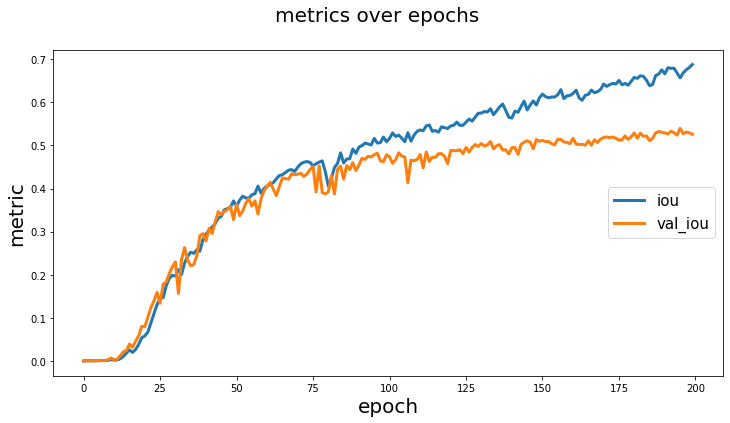

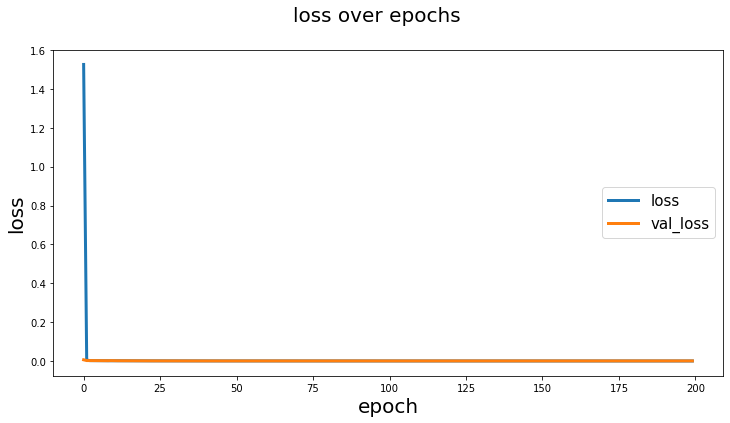

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_val)

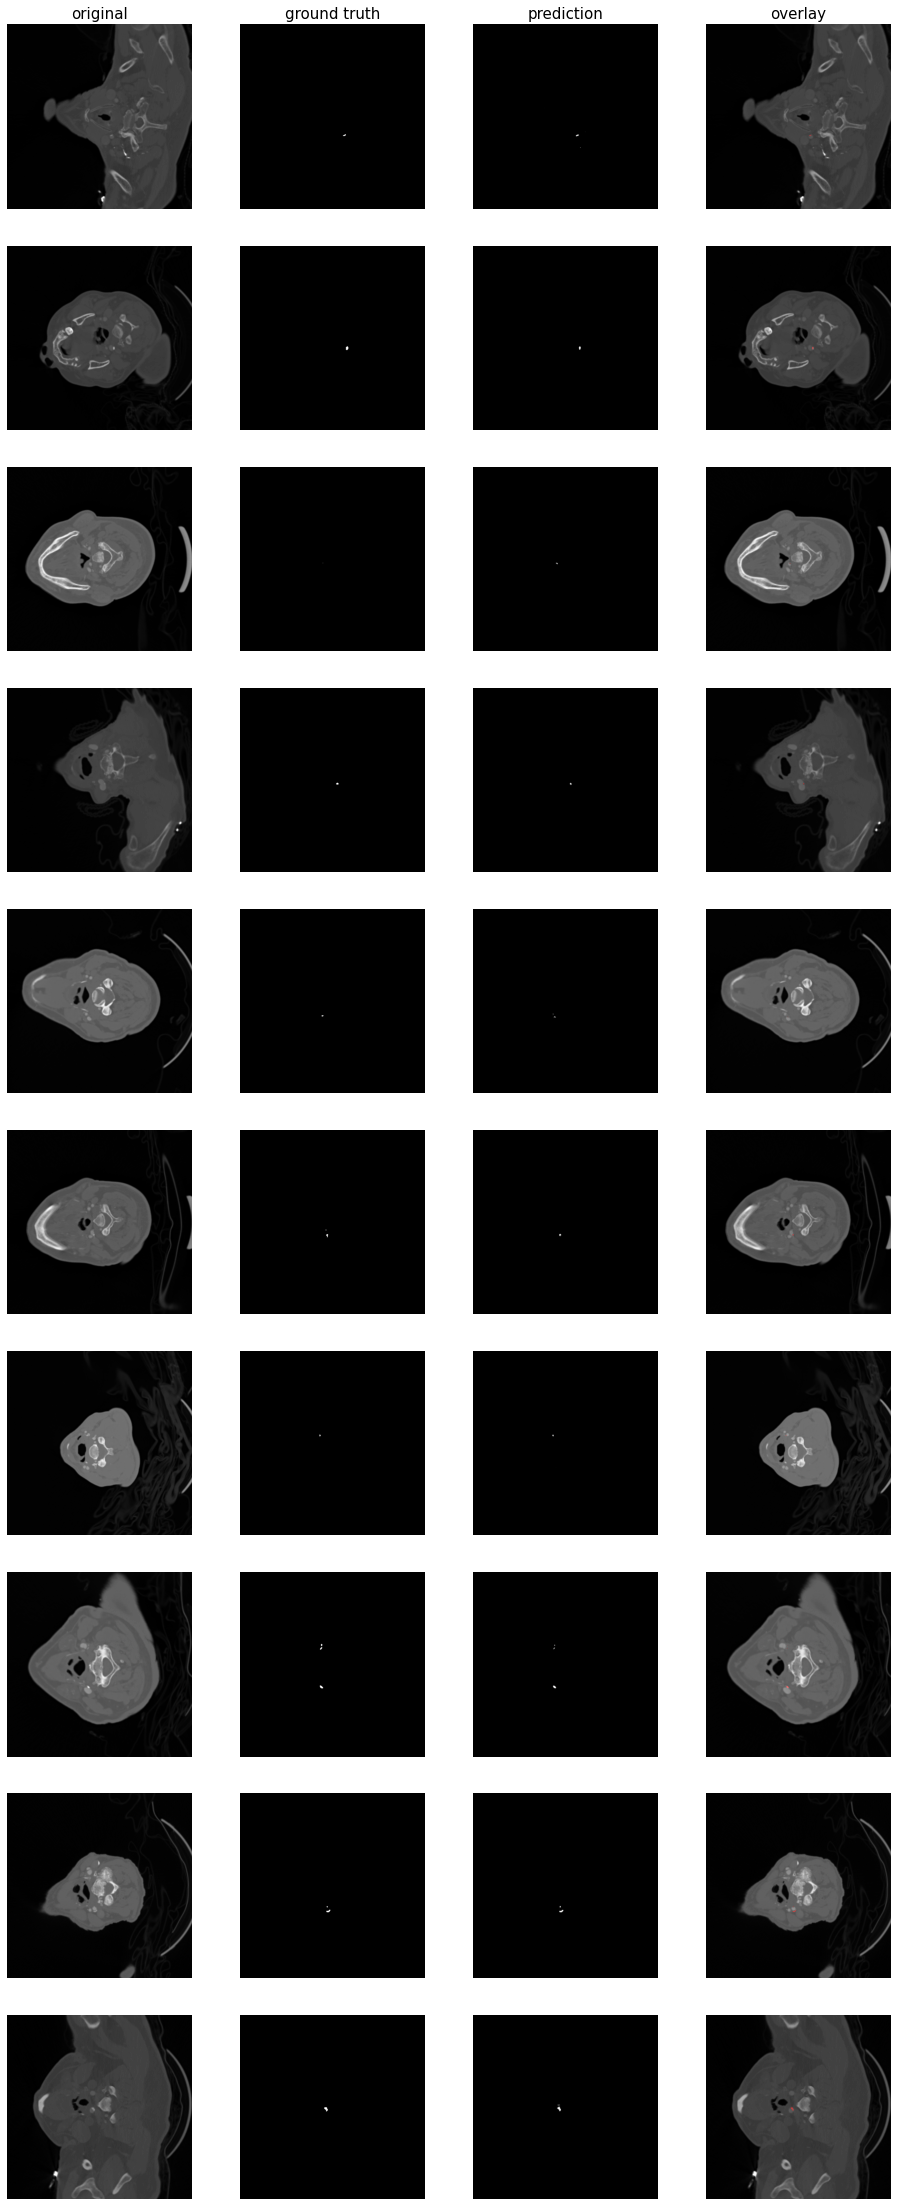

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 1s 203ms/step - loss: 4.9741e-04 - iou: 0.5259 - iou_thresholded: 0.5675
